In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.utils import plot_model

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

***

In [3]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    load_raw_image_description_map, init_image_descriptions_map,
    load_set_images, init_image_descriptions_map_set,
    data_generator
)

from src.utils.image import load_image, load_image_embedding_map
from src.utils.sequence import clean, init_idx_word_map, init_word_idx_map, load_word_embedding_map

from src.nn import InceptionV3Encoder, TopImageEncoder, SequenceDecoder, NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
raw_image2description = load_raw_image_description_map()

print('\n'.join(raw_image2description[:10]))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

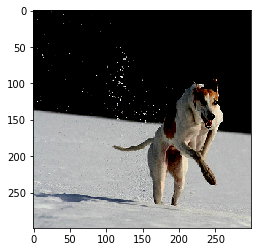

In [15]:
image2descriptions = init_image_descriptions_map()

plt.imshow(load_image('101654506_8eb26cfb60'));
image2descriptions['101654506_8eb26cfb60']

***

## Data Cleaning

In [16]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [17]:
for img_name, descriptions in image2descriptions.items():
    image2descriptions[img_name] = [clean(descr) for descr in descriptions]

In [18]:
image2descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [19]:
vocabulary = set()

for key in image2descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image2descriptions[key]]

In [20]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [21]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [22]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [23]:
word2idx = init_word_idx_map(vocabulary)
idx2word = init_idx_word_map(vocabulary)

In [24]:
word2idx['dog']

2224

In [25]:
idx2word[2224]

'dog'

***

## Max Description Length

In [26]:
descriptions = []

for key, val in image2descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [27]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [28]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [29]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps Sets

In [30]:
train_image2descriptions = init_image_descriptions_map_set(train_images, image2descriptions)
dev_image2descriptions = init_image_descriptions_map_set(dev_images, image2descriptions)
test_image2descriptions = init_image_descriptions_map_set(test_images, image2descriptions)

print('Train size: {}'.format(len(train_image2descriptions)))
print('Dev size: {}'.format(len(dev_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [31]:
train_image2descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Creating Image-Embeddin Maps

In [32]:
train_image2embedding = load_image_embedding_map('train', train_image2descriptions)

***

In [33]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# InceptionV3 Encoder (Non-trainable ConvNet)

We are making use of the **Transfer Learning** technique.<br>
We are using the CNN Inception V3 trained on ImageNet by Google Brain team on Cloud TPUs.
<br><br>

Here is the network architecture:
![InceptionV3](../../img/InceptionV3.png)

In [34]:
inceptionv3_encoder = InceptionV3Encoder()

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
plot_model(inceptionv3_encoder.model, to_file='inceptionv3_encoder.png', show_shapes=True, show_layer_names=True)

print(inceptionv3_encoder.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

***

# Top Image Encoder (Trainable ConvNet)

In [36]:
top_image_encoder = TopImageEncoder(EMBEDDING_DIM, inceptionv3_encoder.model.output_shape[1])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [37]:
plot_model(top_image_encoder.model, to_file='top_image_encoder.png', show_shapes=True, show_layer_names=True)

print(top_image_encoder.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_embedding_input (Input (None, 2048)              0         
_________________________________________________________________
dropout_encoder_1 (Dropout)  (None, 2048)              0         
_________________________________________________________________
dense_encoder_1 (Dense)      (None, 1024)              2098176   
_________________________________________________________________
relu_encoder_1 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_encoder_2 (Dropout)  (None, 1024)              0         
_________________________________________________________________
dense_encoder_2 (Dense)      (None, 300)               307500    
_________________________________________________________________
relu_encoder_2 (Activation)  (None, 300)               0         
__________

***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../../img/LSTM.png)

### Word Embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/))

In [38]:
# Load the Word Embeddings
word2embedding = load_word_embedding_map()

In [39]:
def cosine_similarity(v, w):
    return np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))

In [40]:
cosine_similarity(
    word2embedding['man'] - word2embedding['woman'],
    word2embedding['king'] - word2embedding['queen']
)

0.40070248182725027

## Build the Sequence Decoder

In [41]:
sequence_decoder = SequenceDecoder(
    max_description_length, EMBEDDING_DIM, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

In [42]:
plot_model(sequence_decoder.model, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
glove_embeddings (Embedding)    (None, 37, 300)      2630100     sequence_input[0][0]             
__________________________________________________________________________________________________
image_embedding_input (InputLay (None, 1, 300)       0                                            
__________________________________________________________________________________________________
lstm_decoder_1 (LSTM)           multiple             570368      image_embedding_input[0][0]      
                                                                 embeddings_dropout[0][0]         
          

***

# Model

![NIC_model](../../img/NIC.png)

In [43]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

In [44]:
plot_model(neural_image_captioning.model, to_file='neural_image_captioning.png', show_shapes=True, show_layer_names=True)

print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

# Inference

![LSTM_sampling](../../img/Sampling.png)

***